<a href="https://colab.research.google.com/github/krishnamanc/PytorchPractice/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std
])

In [3]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6279716.56it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1129259.75it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 10023045.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 13511013.31it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Define the split sizes
train_size = 55000
val_size = 5000

# Generate a list of indices and split it into train and validation sets
indices = list(range(len(trainset)))
train_indices = indices[:train_size]  # First 55,000 indices for training
val_indices = indices[train_size:train_size + val_size]  # Next 5,000 indices for validation

# Create samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

In [5]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=False, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1,16,3,1,1),
        nn.MaxPool2d(2,2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(16),
        nn.Conv2d(16,32,3,1,1),
        nn.MaxPool2d(2,2),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32)
    )

    self.classifier = nn.Sequential(
        nn.Linear(32*7*7,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,64),
        nn.ReLU(inplace=True),
        nn.Linear(64,32),
        nn.ReLU(inplace=True),
        nn.Linear(32,16),
        nn.ReLU(inplace=True),
        nn.Linear(16,10)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [7]:
model = Model()

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [9]:
epochs = 1

The inputs are reshaped using inputs.view(-1, 1, 28, 28) to convert them into the correct 4D format expected by the convolutional layers ([batch_size, channels, height, width]). Adjust the channel dimension (1 in this case) based on your data's actual number of channels. For grayscale images like MNIST, the channel dimension is typically 1. For RGB images, it's 3.

In [19]:
model = torch.load("model.pth")

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
for epoch in range(epochs):
    model.train()  # Set the model in training mode explicitly

    # Train the model
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.view(-1, 1, 28, 28) # Reshape inputs to [batch_size, channels, height, width]

        # Forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/1, Loss: 0.0209


In [20]:
correct, total = 0, 0
predictions = []
model.eval()

for i, data in enumerate(val_loader, 0):
  inputs, labels = data
  inputs = inputs.view(-1, 1, 28, 28)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.data, 1)
  predictions.append(outputs)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()

print("Accuracy on validation set : %d %",(100 * correct / total))

Accuracy on validation set : %d % 99.0


In [21]:
correct, total = 0, 0
predictions = []
model.eval()

for i, data in enumerate(test_loader, 0):
  inputs, labels = data
  inputs = inputs.view(-1, 1, 28, 28)
  outputs = model(inputs)
  _, predicted = torch.max(outputs.data, 1)
  predictions.append(outputs)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()

print("Accuracy on test set : %d %",(100 * correct / total))

Accuracy on test set : %d % 99.06


In [15]:
# torch.save(model, 'model6.pth')

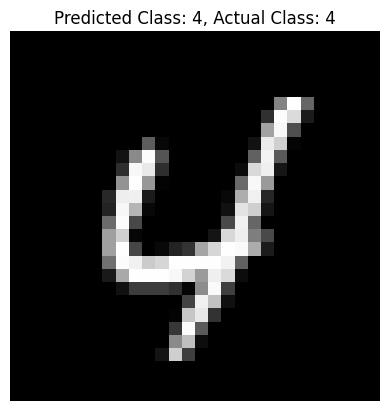

In [22]:
import random
import matplotlib.pyplot as plt

# Select a random image from the test dataset
random_idx = random.randint(0, len(testset) - 1)
random_image, random_label = testset[random_idx]

model.eval()  # Set the model to evaluation mode

# Make predictions
with torch.no_grad():
    output = model(random_image.unsqueeze(0))  # Add batch dimension

# Get the predicted class (assuming it's a classification model)
predicted_class = torch.argmax(output, dim=1).item()

# Plot the random image using Matplotlib
plt.imshow(random_image.squeeze(), cmap='gray')  # Plot the image (remove the batch dimension)
plt.title(f'Predicted Class: {predicted_class}, Actual Class: {random_label}')
plt.axis('off')
plt.show()

In [17]:
# from torchsummary import summary
# # Move the model to the GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# # Define the input size as a tuple of integers
# input_size = (1, 28, 28)  # Assuming input size is (channels, height, width)

# # Use torchsummary to print the model summary
# summary(model, input_size=input_size)